In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error 
import optuna


In [3]:
sys.path.insert(1, '/home/ujwal/ML_program/Trading_financial_market/Predicting_AUDUSD_Using_Major_Regression_Models')
from ipynb.fs.defs.Data_preprocessing import sampling_1target

n_steps = 60

train_X, train_Y, val_X, val_Y, test_X, test_Y,   = sampling_1target(n_steps)


In [3]:
train_X[2]

array([0.82267, 0.82327, 0.82157, 0.82217, 0.82237, 0.82137, 0.82137,
       0.82157, 0.81957, 0.82017, 0.82047, 0.82077, 0.82087, 0.82117,
       0.82287, 0.82257, 0.82117, 0.82037, 0.82067, 0.82487, 0.82397,
       0.82447, 0.82457, 0.82667, 0.82647, 0.82357, 0.82487, 0.82467,
       0.82287, 0.82417, 0.82357, 0.82547, 0.82437, 0.82407, 0.82267,
       0.82187, 0.82357, 0.82387, 0.82447, 0.82447, 0.82547, 0.82797,
       0.82737, 0.82727, 0.82437, 0.82497, 0.82377, 0.82377, 0.82237,
       0.81907, 0.82227, 0.82177, 0.82237, 0.82077, 0.81957, 0.81967,
       0.82347, 0.82427, 0.82567, 0.82447])

In [4]:
train_Y[1]

0.82447

In [5]:
train_Y[2]

0.82227

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
def return_score(param):
    gbm = LGBMRegressor(**param)  
    mae = np.mean(cross_val_score(gbm,train_X, train_Y, cv = 4, n_jobs =-1,scoring=make_scorer(mean_absolute_error)))
    return mae


In [24]:
param={}
a = return_score(param)
a

0.0023236188736566526

In [25]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [26]:
import sklearn
def objective(trial):
    param = {
        'random_state': 1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt","dart","goss"]),
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 5, 500),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 2),
        "importance_type": trial.suggest_categorical("importance_type", ["gain", 'split']),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 10),      
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 500)
    }
    return(return_score(param)) # this will return the mae score

    


In [31]:
study = optuna.create_study(storage=None, direction='minimize',sampler=TPESampler(seed=1))
study.optimize(objective, n_trials=1000, show_progress_bar = True, n_jobs=-1)

[I 2022-12-03 08:50:50,901] A new study created in memory with name: no-name-747277bc-370a-4099-af65-e1b8e261b3b6


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-12-03 08:51:18,096] Trial 1 finished with value: 0.03258957327234406 and parameters: {'boosting_type': 'dart', 'n_estimators': 430, 'reg_lambda': 0.10105151642750969, 'num_leaves': 444, 'min_child_weight': 0.08918616960301662, 'importance_type': 'gain', 'min_split_gain': 1.549735045126328, 'min_child_samples': 411}. Best is trial 1 with value: 0.03258957327234406.
[I 2022-12-03 08:51:25,625] Trial 5 finished with value: 0.07376010077942029 and parameters: {'boosting_type': 'dart', 'n_estimators': 344, 'reg_lambda': 0.16004310477795605, 'num_leaves': 473, 'min_child_weight': 0.5246642482070316, 'importance_type': 'gain', 'min_split_gain': 8.653822732807154, 'min_child_samples': 260}. Best is trial 1 with value: 0.03258957327234406.
[I 2022-12-03 08:51:29,712] Trial 6 finished with value: 0.0150398144323573 and parameters: {'boosting_type': 'goss', 'n_estimators': 691, 'reg_lambda': 0.004432410085669737, 'num_leaves': 373, 'min_child_weight': 1.5228928136909055, 'importance_type'

In [32]:
tune_params = study.best_params
tune_params

{'boosting_type': 'gbdt',
 'n_estimators': 432,
 'reg_lambda': 0.03455625760166917,
 'num_leaves': 94,
 'min_child_weight': 0.3298975814318003,
 'importance_type': 'gain',
 'min_split_gain': 8.44265919265563e-05,
 'min_child_samples': 182}

In [33]:
params = {}
print(f"without tuning {return_score(params)}")
print(f"with tuning {return_score(study.best_params)}")

without tuning 0.00351463756130005
with tuning 0.003451681268114131


In [34]:
gbm_T = LGBMRegressor(**tune_params)
gbm_T.fit(X=train_X, y=train_Y, eval_set=[(val_X,val_Y)])

# test data
preds_T = gbm_T.predict(test_X)
pred_labels_T = np.rint(preds_T)
mae_T_t = mean_absolute_error(test_Y, preds_T)

#val data
preds_T_val = gbm_T.predict(val_X)
pred_labels_T_val = np.rint(preds_T_val)
mae_T_v = mean_absolute_error(val_Y, preds_T_val)

print(mae_T_t, mae_T_v)

[1]	valid_0's l2: 0.0256236
[2]	valid_0's l2: 0.0207882
[3]	valid_0's l2: 0.0168695
[4]	valid_0's l2: 0.0136922
[5]	valid_0's l2: 0.0111149
[6]	valid_0's l2: 0.00902523
[7]	valid_0's l2: 0.00733178
[8]	valid_0's l2: 0.00595821
[9]	valid_0's l2: 0.00484447
[10]	valid_0's l2: 0.00394079
[11]	valid_0's l2: 0.00320762
[12]	valid_0's l2: 0.00261257
[13]	valid_0's l2: 0.00212956
[14]	valid_0's l2: 0.00173776
[15]	valid_0's l2: 0.00141932
[16]	valid_0's l2: 0.00116064
[17]	valid_0's l2: 0.000950705
[18]	valid_0's l2: 0.000780142
[19]	valid_0's l2: 0.000641331
[20]	valid_0's l2: 0.000528431
[21]	valid_0's l2: 0.000436751
[22]	valid_0's l2: 0.000362125
[23]	valid_0's l2: 0.000301404
[24]	valid_0's l2: 0.000252016
[25]	valid_0's l2: 0.000211714
[26]	valid_0's l2: 0.000178629
[27]	valid_0's l2: 0.000151908
[28]	valid_0's l2: 0.000129844
[29]	valid_0's l2: 0.000111968
[30]	valid_0's l2: 9.73185e-05
[31]	valid_0's l2: 8.51841e-05
[32]	valid_0's l2: 7.53359e-05
[33]	valid_0's l2: 6.71206e-05
[34]	va

In [37]:
# Unused test dataset
print("Test data")
print("MAE=", mae_T_t, "\n")

# val dataset
print("Val data")
print("MAE=", mae_T_v)

Test data
MAE= 0.0007853205700974589 

Val data
MAE= 0.001906881452761124


Text(0, 0.5, 'Predicted Y')

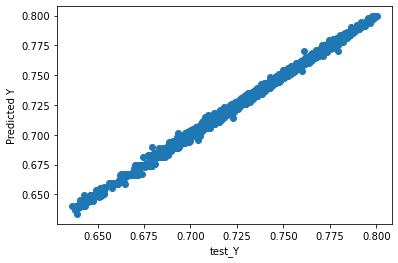

In [40]:
import matplotlib.pyplot as plt
plt.scatter(test_Y,preds_T)
plt.xlabel('test_Y')
plt.ylabel('Predicted Y')

In [41]:
# Check mse using Linear regression
from sklearn import metrics
print('MAE :'," ", metrics.mean_absolute_error(test_Y,preds_T))
print('MSE :'," ", metrics.mean_squared_error(test_Y,preds_T))
print('RMSE :'," ", np.sqrt(metrics.mean_squared_error(test_Y,preds_T)))

MAE :   0.0007853205700974589
MSE :   1.2052933899825184e-06
RMSE :   0.001097858547346842


/home/ujwal/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

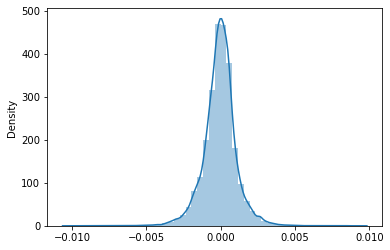

In [42]:
sns.distplot(test_Y - preds_T, bins=50)

In [43]:
# save model using pickle
import pickle
pickle.dump(gbm_T, open('LGBMRegressor.pkl', 'wb'))

In [45]:
# loading model
LGBMRegressor_model = pickle.load(open('LGBMRegressor.pkl', 'rb'))

In [78]:
x = test_X[-1].reshape(1,-1)
x

array([[0.64863, 0.64618, 0.64753, 0.64738, 0.64883, 0.64797, 0.64678,
        0.64743, 0.64954, 0.64985, 0.64988, 0.65018, 0.65078, 0.65067,
        0.64961, 0.64955, 0.64838, 0.64807, 0.65003, 0.64844, 0.65015,
        0.65133, 0.64911, 0.64708, 0.64639, 0.64758, 0.64784, 0.64281,
        0.64353, 0.64299, 0.64193, 0.64071, 0.63957, 0.64023, 0.64023,
        0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023,
        0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023,
        0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023, 0.64023,
        0.64023, 0.64023, 0.64023, 0.64023]])

In [81]:
# 10 day future prediction
x = test_X[-1].reshape(1,-1)
forecast = []

for i in range(10):
    forc = LGBMRegressor_model.predict(X=x)
    forecast = np.append(forecast, forc)
    x = np.append(x, forc)
    x = np.delete(x, 0)
    x = x.reshape(1, -1)
    print(x)

forecast

[[0.64618    0.64753    0.64738    0.64883    0.64797    0.64678
  0.64743    0.64954    0.64985    0.64988    0.65018    0.65078
  0.65067    0.64961    0.64955    0.64838    0.64807    0.65003
  0.64844    0.65015    0.65133    0.64911    0.64708    0.64639
  0.64758    0.64784    0.64281    0.64353    0.64299    0.64193
  0.64071    0.63957    0.64023    0.64023    0.64023    0.64023
  0.64023    0.64023    0.64023    0.64023    0.64023    0.64023
  0.64023    0.64023    0.64023    0.64023    0.64023    0.64023
  0.64023    0.64023    0.64023    0.64023    0.64023    0.64023
  0.64023    0.64023    0.64023    0.64023    0.64023    0.64061688]]
[[0.64753    0.64738    0.64883    0.64797    0.64678    0.64743
  0.64954    0.64985    0.64988    0.65018    0.65078    0.65067
  0.64961    0.64955    0.64838    0.64807    0.65003    0.64844
  0.65015    0.65133    0.64911    0.64708    0.64639    0.64758
  0.64784    0.64281    0.64353    0.64299    0.64193    0.64071
  0.63957    0.64023

array([0.64061688, 0.64061688, 0.64061688, 0.64061688, 0.64061688,
       0.64074465, 0.64074465, 0.64074465, 0.64074465, 0.64074465])

In [82]:
forecast

array([0.64061688, 0.64061688, 0.64061688, 0.64061688, 0.64061688,
       0.64074465, 0.64074465, 0.64074465, 0.64074465, 0.64074465])